# The BioPlex protein-protein interactions data set

## Import packages

In [1]:
''' Python packages '''
import numpy as np
from matplotlib import pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE

''' Project specific tools '''
from data_management import *
from models import *
from display import *
from metrics import *

''' Display configs '''
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Dataset description

In [2]:
data_man = DataManager('BioPlex_PU_data.pkl')
P, U, _, _ = data_man.parse_pickle()

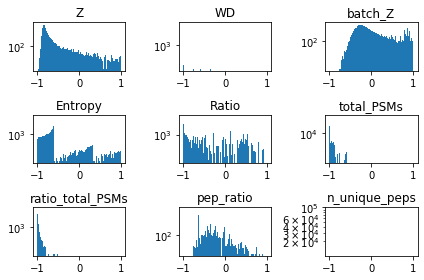

In [4]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, normalize=True)
X_norm = np.concatenate((x_train, x_test))
fig = FigureDrawer('Feature distributions')
fig.draw_hist_array(X_norm.T, labels=data_man.feature_labels)

### Visualize data with dimensionality reduction

In [4]:
x_train, t_train, _, _ = data_man.split_training_test(P, U, test_size=0.03, PU_ratio=8., normalize=True, show_counts=True)
tsne = TSNE(n_jobs=6, perplexity=40, learning_rate=20, early_exaggeration=12, n_iter=5000) # n_iter=2000

len P_train: 1691
len P_test: 44000
len U_train: 13528
len U_test: 312005
 nP/nU: 0.125
len x_train: 15219
len x_test: 356005
nTest/total 0.959003189448958


In [5]:
x_8d = np.delete(x_train, [1,], axis=1)
x_7d = np.delete(x_train, [1,8], axis=1)

X_9d_embedded = tsne.fit_transform(x_train)[::-1]
X_8d_embedded = tsne.fit_transform(x_8d)[::-1]
X_7d_embedded = tsne.fit_transform(x_7d)[::-1]

In [21]:
x_tsne = (
    np.concatenate((X_9d_embedded, t_train[:,np.newaxis][::-1]), axis=1),
    np.concatenate((X_8d_embedded, t_train[:,np.newaxis][::-1]), axis=1), 
    np.concatenate((X_7d_embedded, t_train[:,np.newaxis][::-1]), axis=1), 
)

In [2]:
# remove
import pickle
pickle.dump(x_tsne, open('tsne.pkl', 'wb'))
x_tsne = pickle.load(open('tsne.pkl', 'rb'))

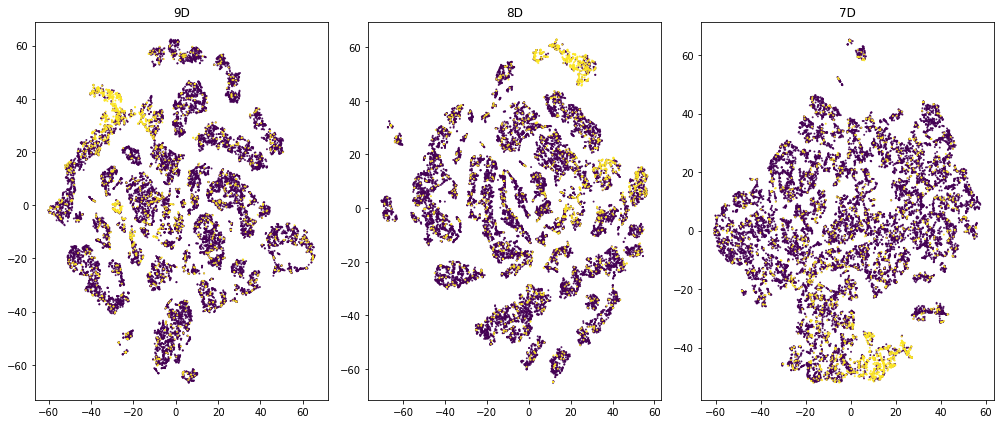

In [5]:
fig = FigureDrawer('T-SNE visualisation')
fig.draw_scatter_plot(x_tsne, titles=['9D', '8D', '7D'], figsize=(14,6))

## Polynomial basis function and linear classifier

In [3]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.5, PU_ratio=1., normalize=True)

In [4]:
lm = Model('linear', C=1, M=6, max_iter=5000)

In [23]:
lm.hyperpar_tuning(x_train, t_train)

{'C': 1, 'M': 3}

In [10]:
lm.train(x_train, t_train)

In [12]:
t_pred = lm.predict(x_test)

In [6]:
metrics = Metrics()

In [15]:
metrics.accuracy(t_pred, t_test)

0.7249676616086494

In [16]:
metrics.recall(t_pred, t_test)

0.5821588024161779

In [17]:
metrics.LL_score(t_pred, t_test)

3.5847061255792437e-06

## Multi Layer Perceptron

In [3]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.5, PU_ratio=5., normalize=True)

In [7]:
mlp = Model('MLP', max_iter=2000)

In [5]:
mlp.train(x_train, t_train)

In [13]:
t_pred = mlp.predict(x_test)

In [6]:
t_pred_proba = mlp.predict(x_test, proba=True)

In [7]:
metrics = Metrics()

In [8]:
curve = metrics.rc_ll_curve(t_pred_proba, t_test)

In [11]:
fig = FigureDrawer('RC - LL curve', figsize=(14,6))
fig.draw_line_plot(lines=[curve, ], 
                   colors=['k',], 
                   labels=['test',], 
                   x_lab='recall', y_lab='LL score')

NameError: name 'curve' is not defined

In [7]:
scores = []
for n in range(10, 105, 5):
    mlp = Model('MLP', n_neurons=n, n_layers=4, max_iter=2000)
    mlp.train(x_train, t_train)
    t_pred = mlp.predict(x_test)
    scores.append((n, metrics.recall(t_pred, t_test), metrics.LL_score(t_pred, t_test)))

In [19]:
pickle.dump(scores, open('scores.pkl', 'wb'))

In [3]:
import pickle
scores = pickle.load(open('scores.pkl', 'rb'))

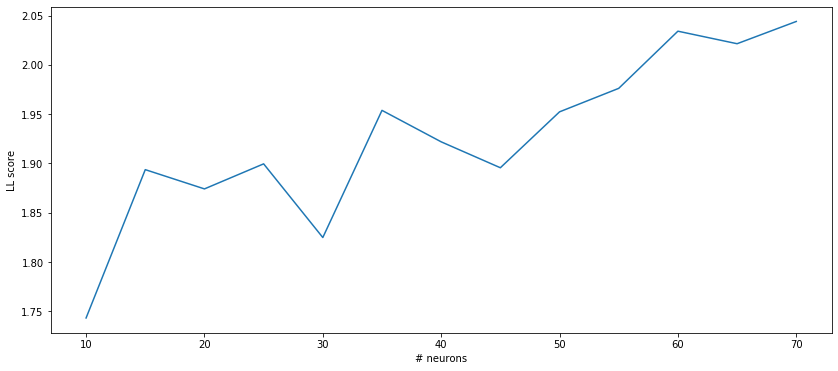

In [9]:
fig = FigureDrawer('varying number of neurons', figsize=(14,6))
fig.draw_line_plot(np.array(scores)[:,0], np.array(scores)[:,2], x_lab='# neurons', y_lab='LL score')

In [10]:
scores = []
for n in range(1, 11):
    mlp = Model('MLP', n_neurons=20, n_layers=n, max_iter=2000)
    mlp.train(x_train, t_train)
    t_pred = mlp.predict(x_test)
    scores.append((n, metrics.recall(t_pred, t_test), metrics.LL_score(t_pred, t_test)))

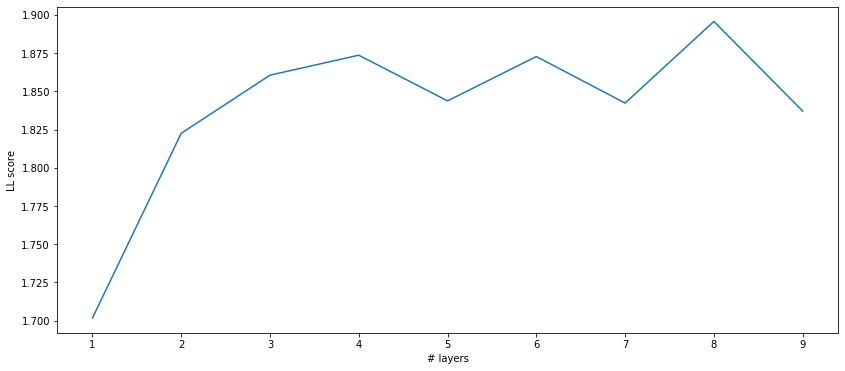

In [12]:
fig = FigureDrawer('varying number of layers', figsize=(14,6))
fig.draw_line_plot(np.array(scores)[:,0], np.array(scores)[:,2], x_lab='# layers', y_lab='LL score')

In [17]:
np.array(scores)[:,1]

array([0.27777291, 0.29142957, 0.2863521 , 0.30180338, 0.30871925,
       0.32867898, 0.34426158])

In [14]:
metrics.accuracy(t_pred, t_test)

0.9128308719902286

In [15]:
metrics.recall(t_pred, t_test)

0.30394817473518343

## Support Vector Machines 

In [3]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.5, normalize=True)

### Radial Basis Funtion Kernel

In [4]:
svm_rbf = Model('SVM', kernel='rbf', C=3, gamma=105.)

In [ ]:
svm_rbf.hyperpar_tuning(x_train, t_train)

In [5]:
svm_rbf.train(x_train, t_train)

In [6]:
t_pred_proba = svm_rbf.predict(x_test, proba=True)

In [7]:
metrics = Metrics()

In [9]:
svm_rbf_curve = metrics.rc_ll_curve(t_pred_proba, t_test)

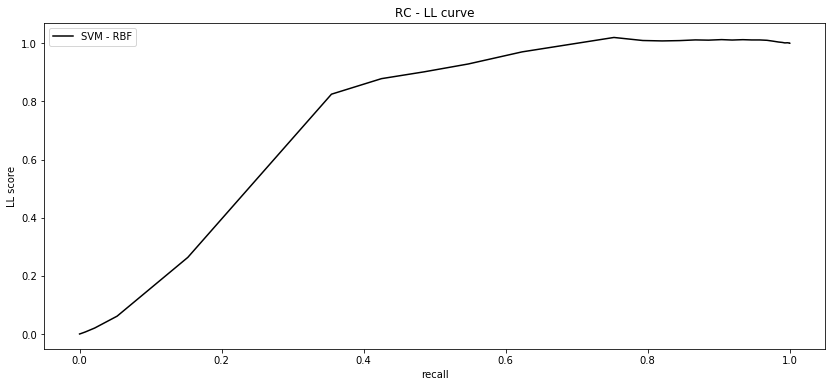

In [10]:
fig = FigureDrawer('RC - LL curve', figsize=(14,6))
fig.draw_line_plot(lines=[svm_rbf_curve, ], 
                   colors=['k',], 
                   labels=['SVM - RBF',], 
                   x_lab='recall', y_lab='LL score')

### Sigmoidal Kernel

In [14]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.95, normalize=True)

In [12]:
svm_sig = Model('SVM', kernel='sigmoid')

In [13]:
svm_sig.train(x_train, t_train)

In [14]:
t_pred_proba = svm_sig.predict(x_test, proba=True)

In [15]:
svm_sig_curve = metrics.rc_ll_curve(t_pred_proba, t_test)

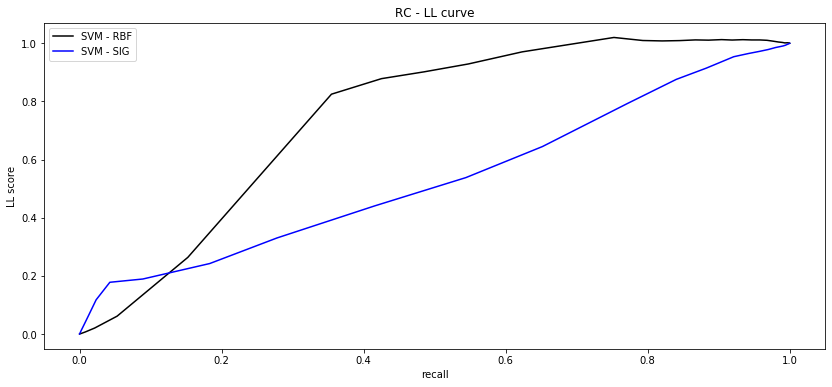

In [16]:
fig = FigureDrawer('RC - LL curve', figsize=(14,6))
fig.draw_line_plot(lines=[svm_rbf_curve, svm_sig_curve], 
                   colors=['k', 'b'], 
                   labels=['SVM - RBF', 'SVM - SIG'], 
                   x_lab='recall', y_lab='LL score')

## Model Ensembles

### SVM ensemble

In [18]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.3, normalize=True)

In [19]:
svm_ens = Ensemble('SVM',  hyperpars={'kernel':'rbf', 'C': 3, 'gamma': 105.}, M=100)

In [20]:
svm_ens.bagging_train(x_train, t_train)

using 479 samples per model.


In [21]:
metrics = Metrics()

In [22]:
t_pred_proba = svm_ens.predict(x_test, proba=True)

In [10]:
bagging_curve = metrics.rc_ll_curve(t_pred_proba, t_test)

In [13]:
svm_array_curves = []
for m in np.random.choice(svm_ens.model_array, 5):
    t_pred_proba = m.predict(x_test, proba=True)
    svm_array_curves.append(metrics.rc_ll_curve(t_pred_proba, t_test))

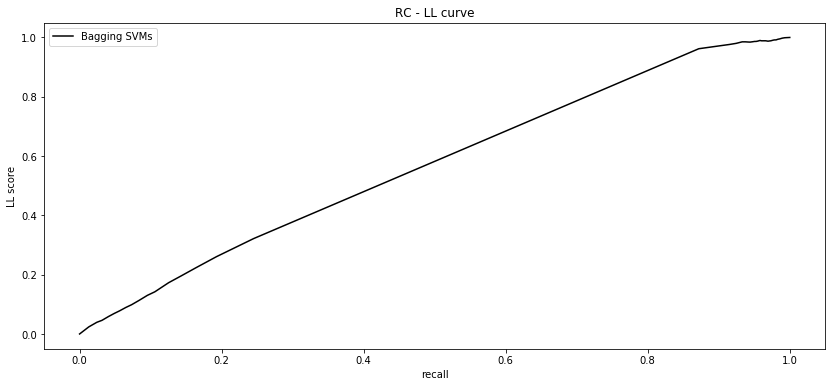

In [12]:
fig = FigureDrawer('RC - LL curve', figsize=(14,6))
fig.draw_line_plot(lines=[bagging_curve, ], 
                   colors=['k', ], 
                   labels=['Bagging SVMs', ], 
                   x_lab='recall', y_lab='LL score')

### MLP ensemble

In [3]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.3, normalize=True)

In [4]:
mlp_ens = Ensemble('MLP', hyperpars={'max_iter':2000, 'n_neurons':30, 'n_layers':4}, M=100)

In [5]:
mlp_ens.bagging_train(x_train, t_train)

using 479 samples per model.


In [6]:
t_pred_proba = mlp_ens.predict(x_test, proba=True)

In [8]:
metrics = Metrics()

In [16]:
bagging_curve = metrics.rc_ll_curve(t_pred_proba, t_test, n_points=50)

In [13]:
mlp_array_curves = []
for m in np.random.choice(mlp_ens.model_array, 5):
    t_pred_proba = m.predict(x_test, proba=True)
    mlp_array_curves.append(metrics.rc_ll_curve(t_pred_proba, t_test, n_points=50))

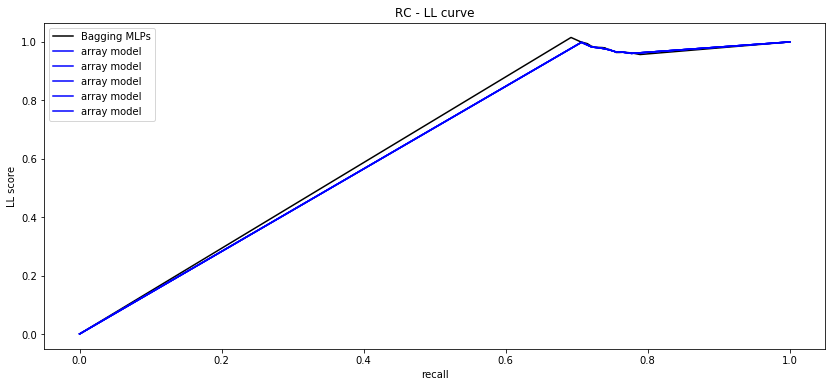

In [17]:
fig = FigureDrawer('RC - LL curve', figsize=(14,6))
fig.draw_line_plot(lines=[bagging_curve, *mlp_array_curves], 
                   colors=['k', *('b',)*len(mlp_array_curves)], 
                   labels=['Bagging MLPs', *('array model',)*len(mlp_array_curves)], 
                   x_lab='recall', y_lab='LL score')

## Compare models

10 fold cross validation

In [6]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.5, PU_ratio=1., normalize=True)

In [ ]:
models = [lm, mlp, svm_rbf, svm_sig,] # svm_ens, mlp_ens
model_perf, model_types = [], []
for m in models:
    model_types.append(m.model_type)
    model_perf.append(m.kfold_cross_val(x_train, t_train, k=10, return_array=True))

In [8]:
s = mlp.kfold_cross_val(x_train, t_train, k=10, return_array=True)

In [9]:
fig = FigureDrawer('Cross Validation Model Comparison', figsize=(14,6))

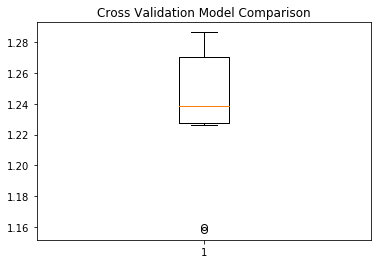

In [13]:
fig.draw_box_plots(data=s,  ) #labels=['mlp', ],y_lab='LL Score'